# Quick Start Example

This is a brief example designed to be run from the already prepared quick_start file, which just puts together some data columns + a target (age) in the same csv (the python file make_quickstart_file.py).

Our main question of interest is going to be: Can cortical thickness ROIs predict participant age? This example will start off very simple and then grow in complexity a bit as the notebook continues.

## Preparing our Dataset

As a first step, we will prepare our data into a BPt [Dataset](https://sahahn.github.io/BPt/reference/api/BPt.Dataset.html) object. If you already familiar with the python library [pandas](https://pandas.pydata.org/), then you might notice that this object looks awfully similar to the pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) object - and you would be right! The Dataset class is built directly ontop of the DataFrame class, just adding some extra functionality / special behavior for working with the BPt.

In this minimal example, this step will be rather be simple. There are 3 different ['roles'](https://sahahn.github.io/BPt/user_guide/role.html) that columns within our Dataset can take. The first 'data' is which by default every loaded column will go into, these are going to be our features that are used to predict some variable of interest (The X variable in a scikit-learn style setup). The second key role is 'target', which are going to be any of our feature(s) which we want to predict (using the columns as input variables). The last is 'non input' which as the name suggests are any variables which we do not want to ever use directly as an input / data variable. 

Here we load data from csv to [Dataset](https://sahahn.github.io/BPt/reference/api/BPt.Dataset.html) directly - the arguments we specify are the file path, which column
we want to be in the index, then also which columns we want in different roles. In  this case, we will specify both sex and age as targets (as later on we may want to predict sex also)

In [1]:
import BPt as bp

# Only display a few columns and rows when showing data
# DELETE me before saving
import pandas as pd
pd.options.display.max_columns = 3 
pd.options.display.max_rows = 5

# Load
data = bp.read_csv('quick_start.csv', index_col='participant_id',
                   targets=['age', 'sex'])

# Set sex as a binary variable
data = data.to_binary('sex')

# Show the first 5 rows of our Dataset
data

lh_G&S_frontomargin_thickness  ...  sex
participant_id                                 ...     
sub-0001                                1.925  ...    1
sub-0002                                2.405  ...    0
...                                       ...  ...  ...
sub-0225                                2.513  ...    0
sub-0226                                3.010  ...    1

[224 rows x 150 columns]

## Visualize some variables

We can visualize any variable easily w/ built in plotting functions. 

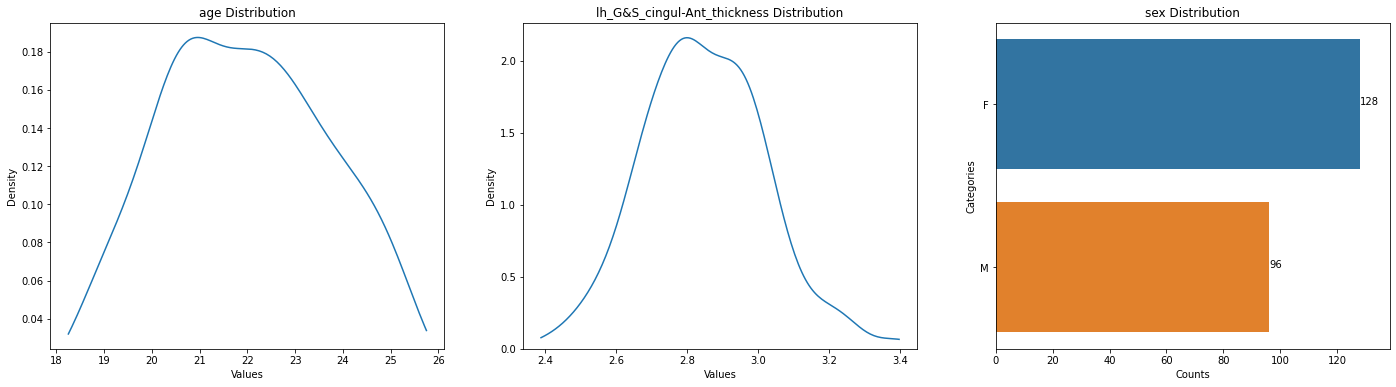

In [2]:
# Show the targets and a random ROI
data.plots(scope=['target', 'lh_G&S_cingul-Ant_thickness'])

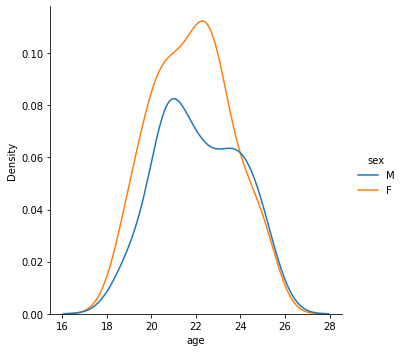

In [3]:
# And / or we could look at a bi-variate plot            
data.plot_bivar('age', 'sex')

## Machine Learning

Next, we will jump in directly to a minimal machine learning example. In this case, our question of interest is can our thickness ROIs predict age, which we have already setup within our dataset by virtue of specifying all cortical thickness ROI's as role='data' and age with role='target'.

To run the experiment itself, we are going to use the `evaluate` method from BPt. This method allows us to perform a number of different ML evaluations and can be customized according a large number of different parameters. In this case though, we are going to provide the bare minimum input needed, and let the default settings take care of everything else.

In particular, we specify that we want to use a default ML pipeline from BPt called 'ridge_pipe' which is pre-defined pipeline based on a regularized ridge regressor w/ nested hyper-parameter search, and also we let the function know our dataset.

In [4]:
results = bp.evaluate(pipeline='ridge_pipe', dataset=data)

Predicting target = age
Using problem_type = regression
Using scope = all (defining a total of 148 features).
Evaluating 224 total data points.


Folds:   0%|          | 0/5 [00:00<?, ?it/s]


Training Set: (179, 148)
Validation Set: (45, 148)
Fit fold in 2.1 seconds.
explained_variance: 0.1786
neg_mean_squared_error: -3.17

Training Set: (179, 148)
Validation Set: (45, 148)
Fit fold in 1.8 seconds.
explained_variance: 0.1446
neg_mean_squared_error: -2.19

Training Set: (179, 148)
Validation Set: (45, 148)
Fit fold in 2.4 seconds.
explained_variance: 0.1142
neg_mean_squared_error: -3.44

Training Set: (179, 148)
Validation Set: (45, 148)
Fit fold in 2.0 seconds.
explained_variance: 0.1005
neg_mean_squared_error: -2.66

Training Set: (180, 148)
Validation Set: (44, 148)
Fit fold in 2.0 seconds.
explained_variance: 0.0243
neg_mean_squared_error: -2.65



We can see from the verbose output above that 5 different training and validation set's were evaluated. This is because the default cross-validation behavior is to run a K-Fold cross validation with 5 folds.

Next, let's look at the returned results object which we saved in variable `results`. 

In [5]:
results

EvalResults
------------
explained_variance: 0.1124 ± 0.0516
neg_mean_squared_error: -2.82 ± 0.4357

Saved Attributes: ['estimators', 'preds', 'timing', 'estimator', 'train_subjects', 'val_subjects', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_', 'cv']

Avaliable Methods: ['to_pickle', 'compare', 'get_X_transform_df', 'get_inverse_fis', 'run_permutation_test', 'get_preds_dfs', 'subset_by', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated With:
target: age
problem_type: regression
scope: all
subjects: all
random_state: 1


This object saves by default a large amount of potentially useful information from the expiriment. This includes the mean evaluation metrics, actual estimator objects, predictions made, information on feature importance and more. 

## Visualizing Results

Let's say we want to look at feature importances. Because the model we ran was a regularized ridge regression, the importances we are going to be looking at are the beta weights from  the model. Further, because we ran a 5-fold CV, we want to look at the beta weights as averaged across each of our 5 models:

In [6]:
fis = results.get_fis(mean=True)
fis

lh_G&S_cingul-Ant_thickness           0.035434
lh_G&S_cingul-Mid-Ant_thickness      -0.117493
                                        ...   
rh_S_temporal_sup_thickness          -0.003753
rh_S_temporal_transverse_thickness   -0.070986
Length: 148, dtype: float32

Next, let's plot our results. For this, we will use an "auto-magical" plotting function from the library neurotools (designed to compliment BPt).

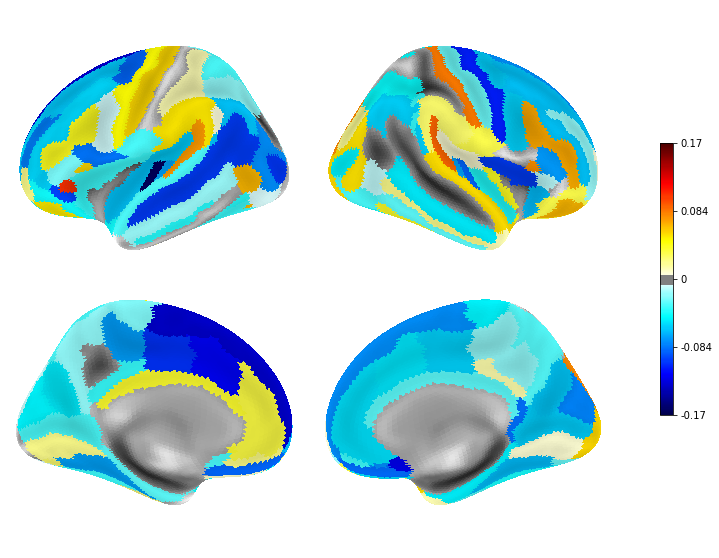

In [7]:
from neurotools.plotting import plot
plot(fis)

This plotting function tries to basically automate everything.  This includes, as an important caveat, an automatic conversion from ROI names to their associated parcellation - which for now only supports a small number of underlying parcellations, including of course our current freesurfer based destr. parcellation.

Next, we will plot the same feature importances again, but this time go a little further to add some customization. We will customize here  by adding a user-defined threshold in which to not show results under, a title and lastly specify that we want to plot results in a higher resolution surface space (rather than the auto-detected one). We will also save the figure with matplotlib

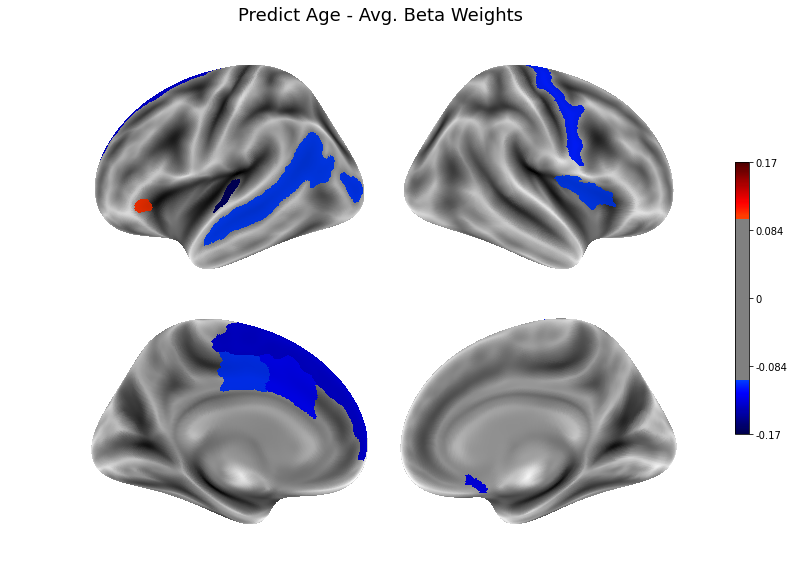

In [8]:
import matplotlib.pyplot as plt

plot(fis,
     threshold=.1,
     title='Predict Age - Avg. Beta Weights',
     space='fsaverage')

plt.savefig('example.png', dpi=100)

Not too bad right? Putting everything together we can perform the full analyses so far in just a few lines of code:

```
# Load data + set structure + binarize sex
data = bp.read_csv('quick_start.csv', index_col='participant_id',
                   targets=['age', 'sex']).to_binary('sex')

# Evaluate w/ ML
results = bp.evaluate(pipeline='ridge_pipe', dataset=data)

# Plot average beta weight
plot(results.get_fis(mean=True))

# And save the figure
plt.savefig('example.png', dpi=100)
```

## Conclusion

This was just a very simple example to help you get started with using BPt. If you are interested in more examples using the open-source AOIMIC datasets, you can check out the [tutorial github](https://github.com/sahahn/methods_series) for using BPt + neurotools for performing a number of different analysis on the AOIMIC datasets. You can also check out other BPt examples in the [BPt documentation](https://sahahn.github.io/BPt/user_guide/bmi_full_example.html).